In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
techsash_waste_classification_data_path = kagglehub.dataset_download('techsash/waste-classification-data')

print('Data source import complete.')


#Mengimpor Dataset dari Kaggle ke Google Colab

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"achmadkhusnafz","key":"f1f6b480a25e891f2d0f6e5d54cfdb52"}'}

#Mengatur API Kaggle

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


#Mendownload Dataset dari Kaggle

In [ ]:
!kaggle datasets download -d techsash/waste-classification-data


Dataset URL: https://www.kaggle.com/datasets/techsash/waste-classification-data
License(s): CC-BY-SA-4.0
 96% 409M/427M [00:02<00:00, 190MB/s]
100% 427M/427M [00:02<00:00, 194MB/s]


#Mengekstrak File ZIP

In [ ]:
import zipfile
with zipfile.ZipFile("waste-classification-data.zip", 'r') as zip_ref:
    zip_ref.extractall("waste_classification_data")


#Memeriksa Struktur Folder yang Diekstraksi

In [ ]:
!ls waste_classification_data


dataset  DATASET


#Mengimpor Library yang Diperlukan

In [ ]:
import os
import time
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')
notebook_start_time = time.time()

<div style="color:white;display:fill;border-radius:5px;background-color:#C0C0C0;font-size:100%;letter-spacing:0.3px">
    <p style="padding: 5px;color:black;"><b><i><i><b></b></i>SETTING UP DATA FILE PATHS</i></b></p>
</div>

#Menyiapkan Path untuk Train dan Test Data

In [ ]:
img_train_path = 'waste_classification_data/DATASET/TRAIN'
img_test_path = 'waste_classification_data/DATASET/TEST'


<div style="color:white;display:fill;border-radius:5px;background-color:#C0C0C0;font-size:100%;letter-spacing:0.3px">
    <p style="padding: 5px;color:black;"><b><i><i><b></b></i>DATA GENERATORS FOR IMAGE CLASSIFICATION</i></b></p>
</div>

#Setup ImageDataGenerator untuk Tiga Kelas

In [ ]:
# Setup ImageDataGenerator untuk dua kelas (O, R)
data_gen = ImageDataGenerator(rescale=1./255, fill_mode='reflect')
val_gen = ImageDataGenerator(rescale=1./255)

# Membuat generator untuk training dengan dua kelas
train_gen = data_gen.flow_from_directory(
    img_train_path,
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical'
)

# Membuat generator untuk validation dengan dua kelas
validation_gen = val_gen.flow_from_directory(
    img_test_path,
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical'
)


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


<div style="color:white;display:fill;border-radius:5px;background-color:#C0C0C0;font-size:100%;letter-spacing:0.3px">
    <p style="padding: 5px;color:black;"><b><i><i><b></b></i>CLASS INDICES AND LABELS</i></b></p>
</div>


#Verifikasi Kelas yang Dikenali oleh Generator

In [ ]:
# Verifikasi kelas yang dikenali oleh generator
print("Train indices:", train_gen.class_indices)
print("Validation indices:", validation_gen.class_indices)


Train indices: {'O': 0, 'R': 1}
Validation indices: {'O': 0, 'R': 1}


<div style="color:white;display:fill;border-radius:5px;background-color:#C0C0C0;font-size:100%;letter-spacing:0.3px">
    <p style="padding: 5px;color:black;"><b><i><i><b></b></i>SAMPLE IMAGES WITH LABELS</i></b></p>
</div>


#Visualisasi Batch Data dari Generator

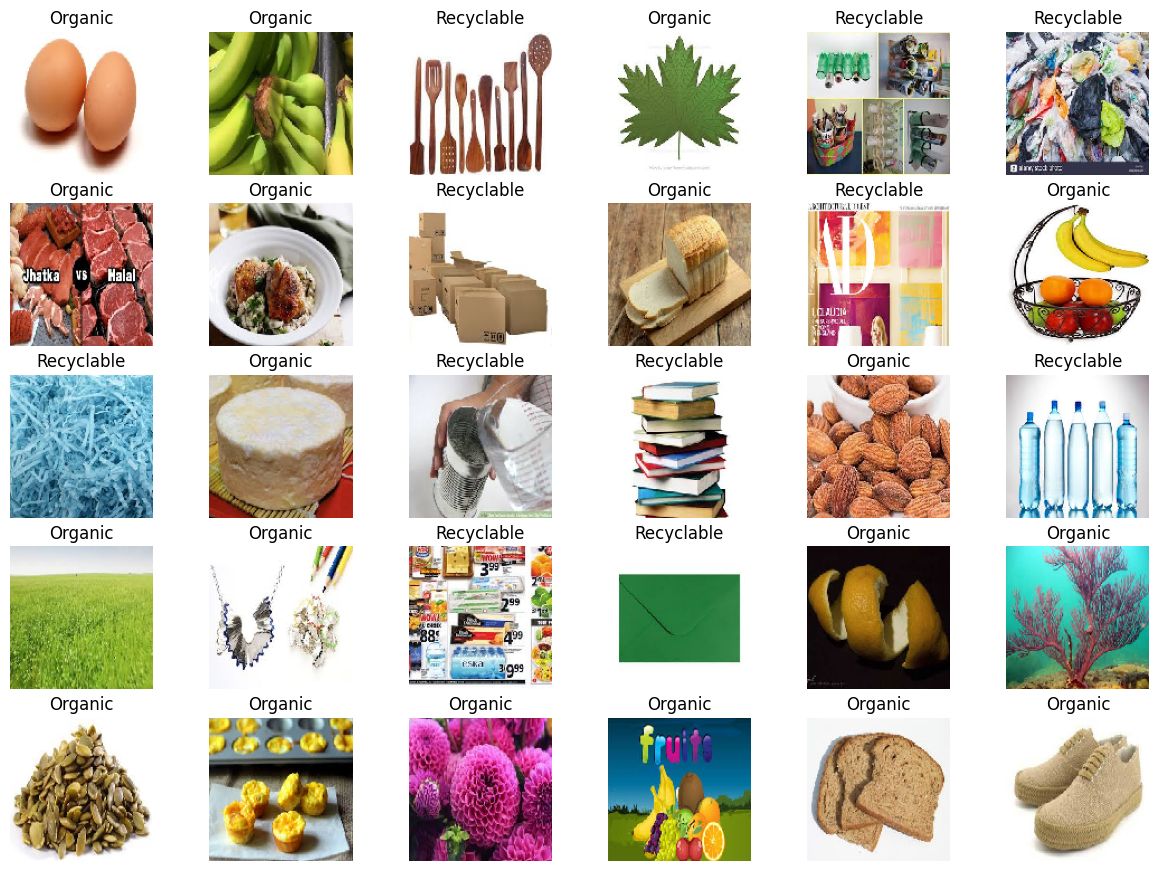

In [ ]:
# Visualisasi batch data dari generator untuk melihat apakah label dikenali dengan benar
img, labels = next(train_gen)
plt.figure(figsize=(15, 13))
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])
    if np.argmax(labels[i]) == 0:
        plt.title("Organic")
    else:
        plt.title("Recyclable")
    plt.axis("off")
del img, labels


<div style="color:white;display:fill;border-radius:5px;background-color:#C0C0C0;font-size:100%;letter-spacing:0.3px">
    <p style="padding: 5px;color:black;"><b><i><i><b></b></i>ADDING CONVOLUTIONAL LAYERS</i></b></p>
</div>

#Membangun Model CNN

In [ ]:
# Membangun model CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),  # Menambahkan layer Flatten
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.001)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.001)),
    tf.keras.layers.Dense(2, activation='softmax')  # Output layer dengan dua kelas
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,781,122 (10.61 MB)

 Trainable params: 2,781,122 (10.61 MB)

 Non-trainable params: 0 (0.00 B)

<div style="color:white;display:fill;border-radius:5px;background-color:#C0C0C0;font-size:100%;letter-spacing:0.3px">
    <p style="padding: 5px;color:black;"><b><i><i><b></b></i>ADDING FULLY-CONNECTED LAYERS WITH WEIGHT DECAY</i></b></p>
</div>

In [ ]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.001)))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l2=0.001)))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │             258 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,815,044 (10.74 MB)

 Trainable params: 2,815,044 (10.74 MB)

 Non-trainable params: 0 (0.00 B)

<div style="color:white;display:fill;border-radius:5px;background-color:#C0C0C0;font-size:100%;letter-spacing:0.3px">
    <p style="padding: 5px;color:black;"><b><i><i><b></b></i>MODEL COMPILATION</i></b></p>
</div>

In [ ]:
# Kompilasi model
model.compile(optimizer='Nadam', loss='CategoricalCrossentropy', metrics=['accuracy'])


In [ ]:
# Konfigurasi callback untuk menyimpan model terbaik dan menghentikan pelatihan lebih awal
best_model = ModelCheckpoint(
    'bestmodel.keras',       # Menggunakan ekstensi .keras untuk menyimpan model terbaik
    monitor='val_loss',      # Metrik yang dipantau
    save_best_only=True,     # Hanya menyimpan model jika val_loss membaik
    mode='min'               # Menggunakan mode 'min' untuk val_loss yang lebih kecil lebih baik
)


<div style="color:white;display:fill;border-radius:5px;background-color:#C0C0C0;font-size:100%;letter-spacing:0.3px">
    <p style="padding: 5px;color:black;"><b><i><i><b></b></i>EARLY STOPPING AND BEST MODEL CHECKPOINTING</i></b></p>
</div>

In [ ]:
# Setup callback untuk early stopping dan model checkpoint
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
best_model = ModelCheckpoint('bestmodel.keras', monitor='val_loss', save_best_only=True)


<div style="color:white;display:fill;border-radius:5px;background-color:#8D918D;font-size:130%;letter-spacing:0.3px">
    <p style="padding: 5px;color:black;text-align:center"><b><b></b><i>TRAINING</i></b></p>
</div>

In [ ]:
# Melatih model
history = model.fit(
    train_gen,
    validation_data=validation_gen,
    epochs=5,
    callbacks=[best_model, early_stopping_monitor]
)


Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 987s 6s/step - accuracy: 0.7152 - loss: 0.8386 - val_accuracy: 0.8822 - val_loss: 0.3841
Epoch 2/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 981s 6s/step - accuracy: 0.8399 - loss: 0.4191 - val_accuracy: 0.8281 - val_loss: 0.3912
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 975s 5s/step - accuracy: 0.8551 - loss: 0.3725 - val_accuracy: 0.9113 - val_loss: 0.2643
Epoch 4/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 969s 5s/step - accuracy: 0.8740 - loss: 0.3352 - val_accuracy: 0.8938 - val_loss: 0.2801
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 997s 6s/step - accuracy: 0.8820 - loss: 0.3122 - val_accuracy: 0.8894 - val_loss: 0.3189


<div style="color:white;display:fill;border-radius:5px;background-color:#C0C0C0;font-size:100%;letter-spacing:0.3px">
    <p style="padding: 5px;color:black;"><b><i><i><b></b></i>TRAINING VS VALIDATION ACCURACY</i></b></p>
</div>

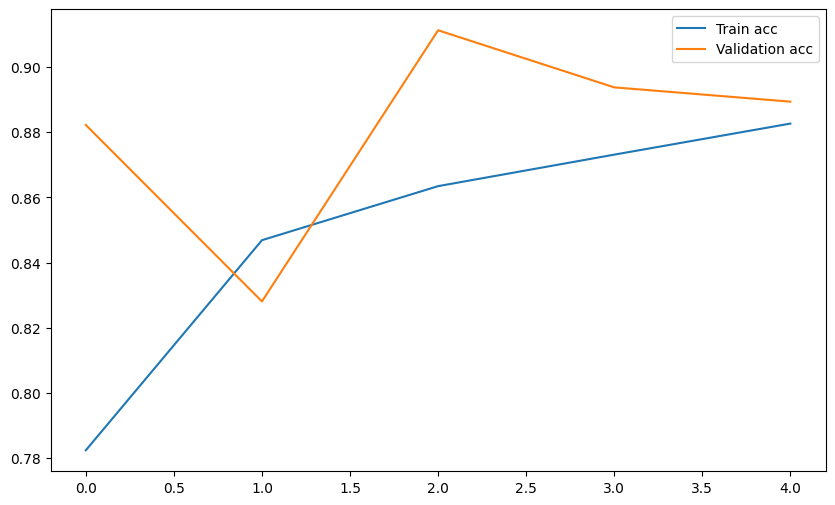

In [ ]:
plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label="Train acc")
plt.plot(history.history["val_accuracy"], label="Validation acc")
plt.legend()
plt.show()


<div style="color:white;display:fill;border-radius:5px;background-color:#C0C0C0;font-size:100%;letter-spacing:0.3px">
    <p style="padding: 5px;color:black;"><b><i><i><b></b></i>TRAINING VS VALIDATION LOSS</i></b></p>
</div>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


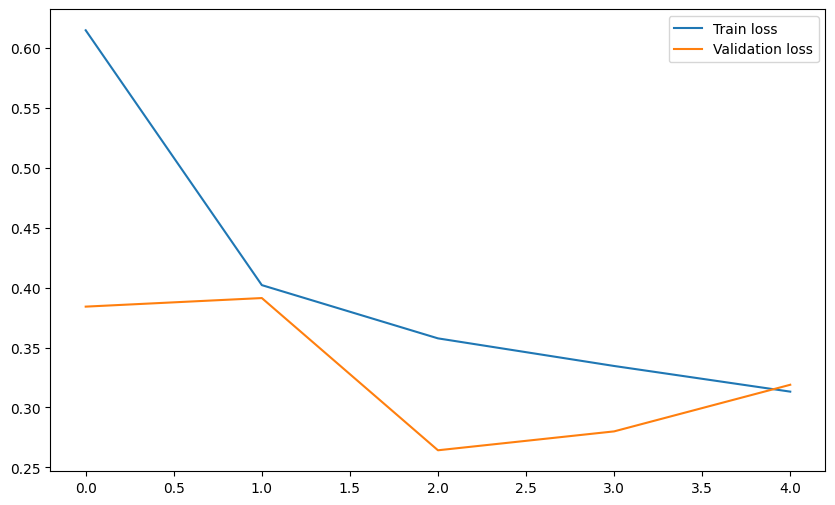

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label="Train loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.show()

<div style="color:white;display:fill;border-radius:5px;background-color:#8D918D;font-size:130%;letter-spacing:0.3px">
    <p style="padding: 5px;color:black;text-align:center"><b><b></b><i>TESTING</i></b></p>
</div>

<div style="color:white;display:fill;border-radius:5px;background-color:#C0C0C0;font-size:100%;letter-spacing:0.3px">
    <p style="padding: 5px;color:black;"><b><i><i><b></b></i>LOADING AND EVALUATING THE BEST MODEL</i></b></p>
</div>

In [ ]:
model.load_weights('bestmodel.keras')
model.evaluate(validation_gen);

20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9097 - loss: 0.2593


<div style="color:white;display:fill;border-radius:5px;background-color:#C0C0C0;font-size:100%;letter-spacing:0.3px">
    <p style="padding: 5px;color:black;"><b><i><i><b></b></i>PREDICTION FUNCTION</i></b></p>
</div>

In [ ]:
def predict_func(img):
    result = model.predict(img)
    return result

<div style="color:white;display:fill;border-radius:5px;background-color:#C0C0C0;font-size:100%;letter-spacing:0.3px">
    <p style="padding: 5px;color:black;"><b><i><i><b></b></i>PREDICTION RESULTS</i></b></p>
</div>

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 512ms/step


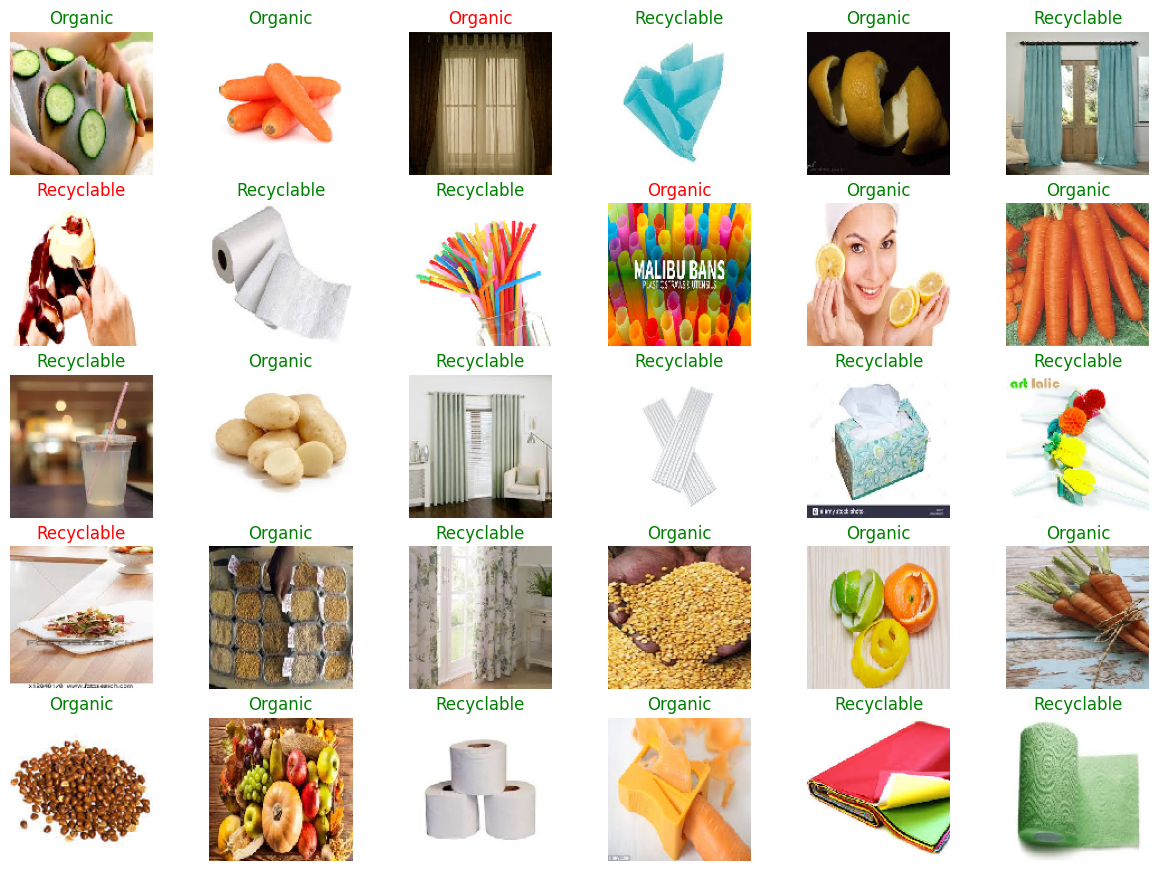

In [ ]:
# Visualisasi prediksi
img, labels = next(validation_gen)
plt.figure(figsize=(15, 13))
result = model.predict(img)
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])
    pred_class = np.argmax(result[i])
    true_class = np.argmax(labels[i])

    if pred_class == 0:
        pred_label = "Organic"
    else:
        pred_label = "Recyclable"

    if pred_class == true_class:
        plt.title(pred_label, color='green')
    else:
        plt.title(pred_label, color='red')

    plt.axis("off")


Menyimpan Model yang Sudah Dilatih

In [ ]:
model.save('bestmodel.keras')
